### The University of Melbourne, School of Computing and Information Systems
# COMP90049 Introduction to Machine Learning, 2022 Semester 2

## Week 3 - Solution

Today, we will be working with a slightly modified version of the (very famous) Iris dataset, first
discussed in:

\begin{align}
{Fisher, R.A. (1936) The Use of Multiple Measurements in Taxonomic Problems, Annual Eugenics
7(II), pp. 179–188.}
\end{align}

This dataset (along with many others) is freely downloadable from the UCI Machine Learning Repository
(https://archive.ics.uci.edu/ml/datasets/Iris). It also comes bundled with scikit-learn,
but we will not be using that version today. 

The dataset and images, along with some of the problems in this worksheet have been adapted from work by Randal Olson (http://www.randalolson.com/) which we use under its Creative Commons license (https://creativecommons.org/licenses/by/4.0/).

Before we start doing anything, let’s frame our problem:
- Let’s say that we would like to build a system that can automatically predict the species of a flower, based on a photograph of that flower.
- The data that we have collected at this point is a description of three kinds of Iris flowers: Iris setosa, Iris versicolor, and Iris virginica. (In the future, we hope to examine other species/genera of flowers.) We believe that the sepals and petals represent one possible source of useful information to help us solve this problem.
- The data was collected by field researchers measuring certain properties of the sepals and petals on a sample of the three kinds of flower. (If some of this information proves useful, then we plan on incorporating image–processing software so that this can be discerned automatically.)

Please ensure that the numpy, matplotlib, defaultdict and re packages are installed.

In [1]:
import numpy as np
from collections import defaultdict
import re
import matplotlib.pyplot as plt
%matplotlib inline

### Exercise 1
Begin by visually inspecting the raw data contained within the (textual) file `iris-data.csv`. Note that “inspecting the data” is mostly ineffectual for very large datasets. In fact, this is one of the main motivators for Machine Learning! :-)

- How many instances are there? How many attributes? The instances have been labelled with class information—so this dataset is suitable for **supervised** machine learning — how many classes are there?

- Confirm your observations by writing a function to count the instances, and keep track of how many instances of each class there are. (You might find the `string.split()` method useful.) 

In [2]:
def count_inst(filestream, class_dict):
    n_instances = 0
    for line in filestream.readlines()[1:]:
        n_instances += 1
        class_dict[line.strip().split(",")[-1]] += 1
    return n_instances

In [4]:
class_dict = defaultdict(int)

f = open("iris-data.csv",'r')

print('Our total number of instances is:',count_inst(f,class_dict))

for lbl in class_dict.keys():
    print('For class', lbl, 'we have', class_dict[lbl], 'instances.')

f.close()

Our total number of instances is: 150
For class Iris-setosa we have 49 instances.
For class Iris-setossa we have 1 instances.
For class Iris-versicolor we have 45 instances.
For class versicolor we have 5 instances.
For class Iris-virginica we have 50 instances.


- You should notice a couple of problems with the class labels; make a copy of the CSV file called `iris-clean.csv`, and edit the erroneous class labels with their (likely) correct values.

`It looks like "setosa" was misspelled for one instance, and a few instances use the short-form "versicolor" instead of the standard "Iris-versicolor". So we first "clean" the data and then check the file again.`

In [5]:
f = open("iris-data.csv",'r')

f_out = open("iris-clean.csv",'w')

for line in f:
    line = re.sub(r'Iris-setossa$','Iris-setosa',line)
    line = re.sub(r',versicolor$',",Iris-versicolor",line)
    f_out.write(line)

f.close()
f_out.close()

In [6]:
n_instances = 0
class_dict = defaultdict(int)

f = open("iris-clean.csv",'r')
# f = open("iris-clean.csv",'r')

print('Our total number of instances is:',count_inst(f,class_dict))

for lbl in class_dict.keys():
    print('For class', lbl, 'we have', class_dict[lbl], 'instances.')

f.close()

Our total number of instances is: 150
For class Iris-setosa we have 50 instances.
For class Iris-versicolor we have 50 instances.
For class Iris-virginica we have 50 instances.


### Exercise 2
Before we can think about building a classifier, we should double–check that the data is formatted **correctly**. Confirm that the first line of the dataset is a header, which describes the expected format.

**(a)** Write a function `check-csv()` which returns `True` if every instance has the same number of fields (in this case, attribute values separated by commas), and `False` otherwise. Tgen check if your file has the correct format.

In [7]:
def check_csv(filestream,n_fields):
    ret_val = True
    for line in filestream:
        if (len(line.strip().split(","))!=n_fields): ret_val = False
    return ret_val

In [8]:
f = open("iris-clean.csv",'r')

header = f.readline()

print("Header: ",header.strip())
n_fields = len(header.strip().split(","))

print("CSV passes? ",check_csv(f,n_fields))
f.close()

Header:  sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class
CSV passes?  True


**(b)** Write a function which, for each attribute, prints the number of instances where the attribute
value is numeric. What do you observe?

In [9]:
def numeric_att_vals(filestream,n_fields):
    att_counts = [0]*n_fields
    for line in filestream:
        instance = line.strip().split(",")
        for ctr in range(n_fields):
            try:
                float(instance[ctr])
                att_counts[ctr]+=1
            except ValueError:
                print("A 'not numeric' value found in field :",ctr+1, ", and it's value is", instance[ctr])
    return att_counts

In [10]:
f = open("iris-clean.csv",'r')

f.readline()
print("Numeric attribute value counts:",numeric_att_vals(f,n_fields-1)) #not including class

f.close()

A 'not numeric' value found in field : 4 , and it's value is NA
A 'not numeric' value found in field : 4 , and it's value is NA
A 'not numeric' value found in field : 4 , and it's value is NA
A 'not numeric' value found in field : 4 , and it's value is NA
A 'not numeric' value found in field : 4 , and it's value is NA
Numeric attribute value counts: [150, 150, 150, 145]


`It seems that "NA" is used for measurements that weren't recorded. Of course, this might also appear in various other ways, like "?", or "N/A", and so on, but not in the data that we're given.`

For the instances with non-numeric attribute values, the values appear to be missing. We can’t know what the true values of these attribute were supposed to be, but leaving them unknown might cause problems for our model.

One possible approach toward solving this issue is replacing the missing values with the **mean of the observed values** for that attribute. 

To check if it an appropriate method for our data. We can use the `matplotlib` library to plot a histogram for the data as follows:

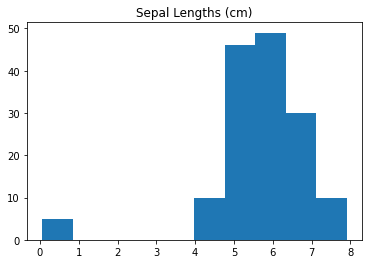

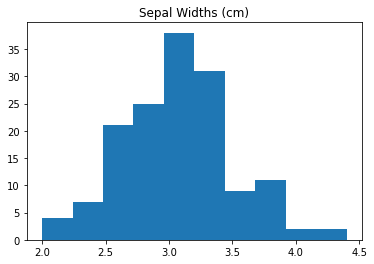

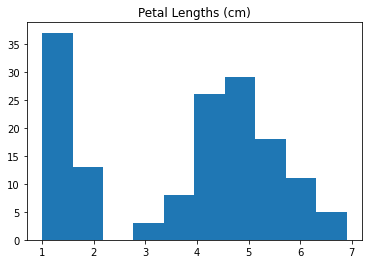

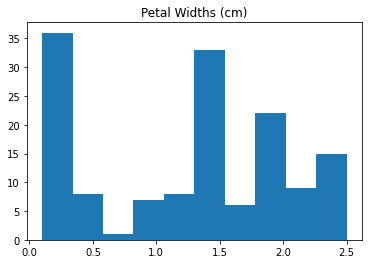

In [11]:
sepal_lengths = []
sepal_widths = []
petal_lengths = []
petal_widths = []

with open("iris-clean.csv",'r') as f:
    f.readline()
    for line in f:
        att_vals = line.strip().split(",")
        sl = att_vals[0]
        if not(sl) == "NA":
            sepal_lengths.append(float(sl))
        sw = att_vals[1]
        if not(sw) == "NA":
            sepal_widths.append(float(sw))
        pl = att_vals[2]
        if not(pl) == "NA":
            petal_lengths.append(float(pl))
        pw = att_vals[3]
        if not(pw) == "NA":
            petal_widths.append(float(pw))
            
plt.title("Sepal Lengths (cm)")
plt.hist(np.array(sepal_lengths))
plt.show()
plt.title("Sepal Widths (cm)")
plt.hist(np.array(sepal_widths))
plt.show()
plt.title("Petal Lengths (cm)")
plt.hist(np.array(petal_lengths))
plt.show()
plt.title("Petal Widths (cm)")
plt.hist(np.array(petal_widths))
plt.show()

**(c)** Explian how these histograms can help us to see check if using the "mean of the observed values" is the proper method for solving the issue of missing value for an attribute

** (d)** Explian why using the **mean of the observed values** is a bad idea for the feature 4 ('Petal Widths'), based on the data you observe? Is there anything else we could do, so as to make mean imputation a plausible strategy here?

`Unlike, say, sepal widths (that has a roghly normal distrubution), the mean value of the petal width distribution (our forth attribute with missing values) doesn't appear to be representative of much of the data.` 

`Based on these bins, the mean isn't even the mode! One possible reason for this is that different classes of Iris might have a different mean petal width: for example, there appear to be roughly three peaks in this distribution (one around 0.3, one around 1.3, and one around 2.0), and three classes. It could also be just a coincidence; we would have to re-plot the data to get a better sense of it:`

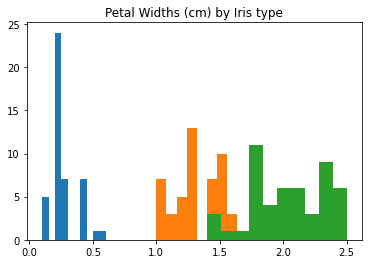

In [12]:
iris_setosa = []
iris_versicolor = []
iris_virginica = []
with open("iris-clean.csv",'r') as f:
    f.readline()
    for line in f:
        att_vals = line.strip().split(",")
        pw = att_vals[3]
        if not(pw) == "NA":
            if att_vals[4] == "Iris-setosa": iris_setosa.append(float(pw))
            elif att_vals[4] == "Iris-versicolor": iris_versicolor.append(float(pw))
            elif att_vals[4] == "Iris-virginica": iris_virginica.append(float(pw))
            else: print("Unexpected class: ",att_vals[4])
                
plt.title("Petal Widths (cm) by Iris type")
plt.hist(np.array(iris_setosa))
plt.hist(np.array(iris_versicolor))
plt.hist(np.array(iris_virginica))
plt.show()

`Here, it appears that if we wanted to guess an unseen value of petal width for an instance of a given class, then the mean value for the instances of that class would appear to be reasonable.`

`Of course, if we didn't know the class in advance (for example, for an instance from the test data, rather than the training) then this style of imputation wouldn't work.`

### Exercise 3
Use the method above to plot the histograms for the other attributes. You should observe some clear **outliers** in the attribute values. Take a look at the raw data, and see if you can guess what could have caused the outliers. Modify your `iris-clean.csv` copy of the data, to fix the outlying attribute values.

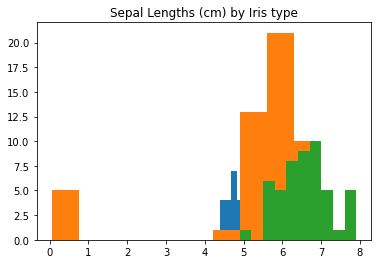

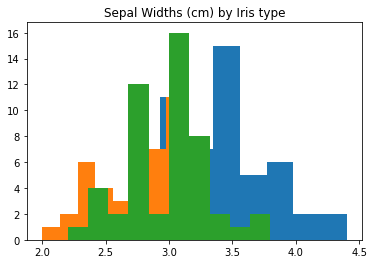

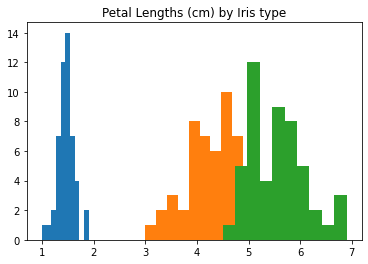

In [13]:
# Using a 2-d (or 3-d) list here would probably be better than several named lists
# But the attribute set is small enough that it should be okay in this context
sl_setosa = []
sw_setosa = []
pl_setosa = []
sl_versicolor = []
sw_versicolor = []
pl_versicolor = []
sl_virginica = []
sw_virginica = []
pl_virginica = []
with open("iris-clean.csv",'r') as f:
    f.readline()
    for line in f:
        att_vals = line.strip().split(",")
        sl = att_vals[0]
        sw = att_vals[1]
        pl = att_vals[2]
        if att_vals[4] == "Iris-setosa":
            if not(sl) == "NA": sl_setosa.append(float(sl))
            if not(sw) == "NA": sw_setosa.append(float(sw))
            if not(pl) == "NA": pl_setosa.append(float(pl))
        elif att_vals[4] == "Iris-versicolor":
            if not(sl) == "NA": sl_versicolor.append(float(sl))
            if not(sw) == "NA": sw_versicolor.append(float(sw))
            if not(pl) == "NA": pl_versicolor.append(float(pl))
        elif att_vals[4] == "Iris-virginica":
            if not(sl) == "NA": sl_virginica.append(float(sl))
            if not(sw) == "NA": sw_virginica.append(float(sw))
            if not(pl) == "NA": pl_virginica.append(float(pl))
        else: print("Unexpected class: ",att_vals[4])
                
plt.title("Sepal Lengths (cm) by Iris type")
plt.hist(np.array(sl_setosa))
plt.hist(np.array(sl_versicolor))
plt.hist(np.array(sl_virginica))
plt.show()
plt.title("Sepal Widths (cm) by Iris type")
plt.hist(np.array(sw_setosa))
plt.hist(np.array(sw_versicolor))
plt.hist(np.array(sw_virginica))
plt.show()
plt.title("Petal Lengths (cm) by Iris type")
plt.hist(np.array(pl_setosa))
plt.hist(np.array(pl_versicolor))
plt.hist(np.array(pl_virginica))
plt.show()

`Most of the sepal lengths of all three kinds of Iris are between 4cm and 8cm, however, there are a small number of Iris-versicolor instances for which the sepal lengths are less than 1cm, which looks a little strange. Let's take a look at them, compared to a sample of the rest of the data:`

In [14]:
print("Short sepal lengths:")
print([x for x in sl_versicolor if x < 1.0])
print("Some regular sepal lengths:")
print([x for x in sl_versicolor if x > 1.0][:10])

Short sepal lengths:
[0.067, 0.06, 0.057, 0.055, 0.055]
Some regular sepal lengths:
[7.0, 6.4, 6.9, 5.5, 6.5, 5.7, 6.3, 4.9, 6.6, 5.2]


`Looking at the data, the smaller values have the same number of significant digits, but are smaller by two orders of magnitude. One possible explanation is that this information was being recorded in m instead of cm on some instances (perhaps because there were multiple people who were doing the data collection, or the software parameters changed, or various other possiblew reasons).`

`We would want to double-check this with the data curators; are these values actually correct, or are they erroneous, and therefore should we attempt to fix them? Let's say that we did discover that these are truly erroneous readings, and that we should multiply them by a factor of 100.`

In [15]:
f = open("iris-data.csv",'r')
f_out = open("iris-clean.csv",'w')

#Pass through the header
f_out.write(f.readline())

for line in f:
    atts = line.strip().split(",")
    if atts[-1] == "Iris-setossa": atts[-1] = "Iris-setosa"
    if atts[-1] == "versicolor": atts[-1] = "Iris-versicolor"
    if float(atts[0]) < 1.0: atts[0]=str(100*float(atts[0]))
    f_out.write(",".join(atts)+"\n")

f.close()
f_out.close()

`For posterity, let's sanity-check the histogram of sepal lengths for the Iris-versicolor instances now.`

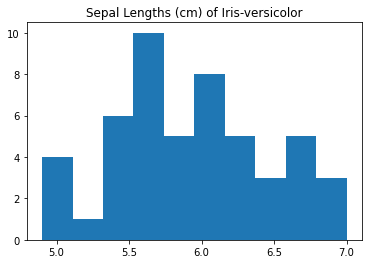

In [16]:
sl_versicolor = []
with open("iris-clean.csv",'r') as f:
    f.readline()
    for line in f:
        att_vals = line.strip().split(",")
        sl = att_vals[0]
        if att_vals[4] == "Iris-versicolor":
            if not(sl) == "NA": sl_versicolor.append(float(sl))
plt.title("Sepal Lengths (cm) of Iris-versicolor")
plt.hist(np.array(sl_versicolor))
plt.show()

### Exercise 4
Let’s attempt to visualise some relationships in the data.

First let's make a scatter-plot of the sepal length vs. sepal width by using the following:

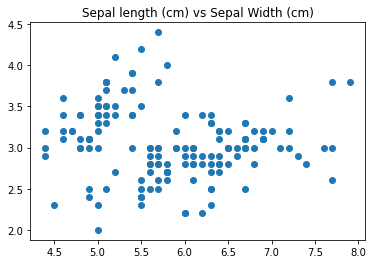

In [17]:
sepal_lengths = []
sepal_widths = []
petal_lengths = []
petal_widths = []
with open("iris-clean.csv",'r') as f:
    f.readline()
    for line in f:
        att_vals = line.strip().split(",")
        sl = att_vals[0]
        if not(sl) == "NA":
            sepal_lengths.append(float(sl))
        sw = att_vals[1]
        if not(sw) == "NA":
            sepal_widths.append(float(sw))
        pl = att_vals[2]
        if not(pl) == "NA":
            petal_lengths.append(float(pl))
        pw = att_vals[3]
        if not(pw) == "NA":
            petal_widths.append(float(pw))
        # Obviously, we would want a better strategy here
        # But it's enough for now to record the handful of missing values as an impossible value
        else: petal_widths.append("0")
            
plt.title("Sepal length (cm) vs Sepal Width (cm)")
plt.scatter(np.array(sepal_lengths),np.array(sepal_widths))
plt.show()

**(a)** Can you identify a certain pattern in it?

`It is suggestive, but without a clear indication of the classes of the instances, we can’t really be certain of any patterns in the data.`

The scatter function takes an optional argument for colouring points, based on a list of strings (like red or blue). Let's replot our data using different colours for different classes.

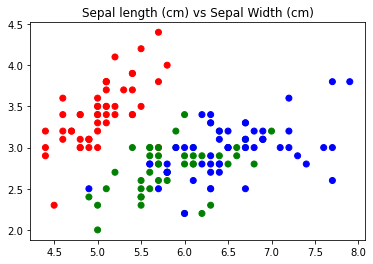

In [18]:
# The data has the instances ordered by class
# The first 50 are Iris-setosa, the next 50 are Iris-versicolor, and the final 50 are Iris-virginica
# If the data wasn't sorted by class, we would have to do some more work here 
colours = 50*["red"]+50*["green"]+50*["blue"]
# As a brief aside, colourblind readers would want to discriminate using value/saturation instead of hue
# and ideally also different shapes for the points of each class
plt.title("Sepal length (cm) vs Sepal Width (cm)")
plt.scatter(np.array(sepal_lengths),np.array(sepal_widths),c=colours)
plt.show()

**(b)** Now can you identify a certain pattern?

`At a casual glance, it appears that most of the Iris-setosa instances (red dots) occupy a distinct "region" of this space (relatively short sepal length, but relatively high sepal width), but for the other two classes, the points are somewhat "mixed up".`

Now let's try making scatter-plots for different pairs of attributes. 

In [ ]:
colours = 50*["red"]+50*["green"]+50*["blue"]
plt.title("Sepal length (cm) vs Petal length (cm)")
plt.scatter(np.array(sepal_lengths),np.array(petal_lengths),c=colours)
plt.show()
plt.title("Sepal length (cm) vs Petal width (cm)")
plt.scatter(np.array(sepal_lengths),np.array(petal_widths),c=colours)
plt.show()
plt.title("Sepal width (cm) vs Petal length (cm)")
plt.scatter(np.array(sepal_widths),np.array(petal_lengths),c=colours)
plt.show()
plt.title("Sepal width (cm) vs Petal width (cm)")
plt.scatter(np.array(sepal_widths),np.array(petal_widths),c=colours)
plt.show()
plt.title("Petal length (cm) vs Petal width (cm)")
plt.scatter(np.array(petal_lengths),np.array(petal_widths),c=colours)
plt.show()

**(c)** Do you notice anything that might suggest that one class is distinguishable from the others? How might this information be utilised by the Naive Bayes algorithm? What about other supervised machine learning methods?

`Each of these plots gives us a little bit of information about some distinguishing characteristics of the data; one simple observation for the first four graphs is that the red instances (Iris-setosa) occupy the lower-most area (low petal length/petal width), the green instances (Iris-versicolor) are in the middle, and the blue instances are near the top (high petal length/petal width).`

`The final graph appears to show a good relationship between two attributes (petal length and petal width), which seems to strongly suggest how to distinguish one class from another. However, the question asks us about Naive Bayes in particular, which might have some slight problems in this case because it uses every attribute value when making a prediction; sepal width doesn't look like a useful predictor in this context, even when combined with each of the other attributes.`

`As the semester continues, we'll talk more about how Naive Bayes manipulates these numerical attributes, and some other methods (like Support Vector Machines) that can better discover some of the discriminating factors that we can readily observe in this case of the Iris data. This is important, because with a larger attribute set, say 1000 or so, we might not be able to sensibly examine all of the pairwise scatterplots; and even if we could, it might be the case that it is the combination of three (or more) attributes which allows us to discriminate the data; we can't realistically observe such a thing by inspection.`